# FIFA World Cup 2018 Predictions
----
![FIFA World Cup 2018](https://upload.wikimedia.org/wikipedia/en/thumb/6/67/2018_FIFA_World_Cup.svg/227px-2018_FIFA_World_Cup.svg.png)

## Description
Data analysis and prediction of FIFA World Cup 2018 Russia match results using machine learning approach and match simulation

## Datasets:
* [FIFA World Cup 2018 Dataset on Kaggle](https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset)
* [FIFA Soccer Rankings: International Men's Ranking (August 1993 - June 2018)](https://www.kaggle.com/tadhgfitzgerald/fifa-international-soccer-mens-ranking-1993now)
* [International football results from 1872 to 2018](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017)

## References
----
* Soccer World Cup 2018 Winner [by Dr. James Bond](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner)
* FIFA - May the force be with the strongest team [by Wei Chun Chang](https://www.kaggle.com/justjun0321/fifa-may-the-force-be-with-the-strongest-team)
* World Cup Winner Prediction 2018
 [by MJeremy](https://www.kaggle.com/zhangyue199/world-cup-winner-prediction-2018)
 
## Author
----
* **[Christian Wibisono](https://www.kaggle.com/christianwbsn)**

----
----

## World Cup 2018 Analysis
----
### Importing Libraries for EDA and Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline
import numpy as np
import seaborn as sns

### Loading dataset to dataframe

In [2]:
# Historical FIFA rankings dataframe
historical_rankings = pd.read_csv('../input/fifa_ranking.csv')
# Historical match between 2 teams dataframe
historical_matches = pd.read_csv('../input/results.csv')
world_cup = pd.read_csv('../input/world_cup_2018.csv')

In [3]:
historical_rankings = historical_rankings.replace({'IR Iran': 'Iran'})
historical_matches = historical_matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

### 1. Exploratory Data Analysis
----

In [4]:
print("Historical FIFA Rankings:")
print(historical_rankings.info())
print("--------------------------------")
print("Historical matches")
print(historical_matches.info())

Historical FIFA Rankings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57793 entries, 0 to 57792
Data columns (total 16 columns):
rank                       57793 non-null int64
country_full               57793 non-null object
country_abrv               57793 non-null object
total_points               57793 non-null float64
previous_points            57793 non-null int64
rank_change                57793 non-null int64
cur_year_avg               57793 non-null float64
cur_year_avg_weighted      57793 non-null float64
last_year_avg              57793 non-null float64
last_year_avg_weighted     57793 non-null float64
two_year_ago_avg           57793 non-null float64
two_year_ago_weighted      57793 non-null float64
three_year_ago_avg         57793 non-null float64
three_year_ago_weighted    57793 non-null float64
confederation              57793 non-null object
rank_date                  57793 non-null object
dtypes: float64(9), int64(3), object(4)
memory usage: 7.1+ MB
None
--------

* ## Historical Rankings data

In [5]:
# Processing rankings data
historical_rankings = historical_rankings.loc[:,['rank', 'country_full','country_abrv', 'total_points', 'confederation', 'rank_date']]
historical_rankings['rank_date'] = pd.to_datetime(historical_rankings['rank_date'])
historical_rankings = historical_rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
historical_rankings.head()

,rank_date,rank,country_full,country_abrv,total_points,confederation
0,2003-01-15,204.0,Afghanistan,AFG,0.0,AFC
1,2003-01-16,204.0,Afghanistan,AFG,0.0,AFC
2,2003-01-17,204.0,Afghanistan,AFG,0.0,AFC
3,2003-01-18,204.0,Afghanistan,AFG,0.0,AFC
4,2003-01-19,204.0,Afghanistan,AFG,0.0,AFC


In [6]:
historical_rankings_by_team = historical_rankings.groupby([historical_rankings.rank_date.dt.year,historical_rankings.country_full]).mean()
historical_rankings_by_team = historical_rankings_by_team.reset_index()

In [7]:
print("Top 10 Averaged World Rank since 1993")
historical_rankings_by_team.groupby(['country_full']).mean().sort_values(by=['rank'])['rank'][:10]

Top 10 Averaged World Rank since 1993


country_full
Brazil          3.085171
Germany         4.960291
Spain           5.485745
Argentina       5.690997
Italy           8.218103
France          9.087425
Netherlands     9.136396
England        10.826872
Portugal       11.731863
Mexico         14.675684
Name: rank, dtype: float64

In [8]:
print("Top 32 Teams Averaged World Rank That Failed to Qualify to World Cup 2018")
top_32 = historical_rankings_by_team.groupby(['country_full']).mean().sort_values(by=['rank'])['rank'][:32].reset_index()
not_in_world_cup_2018 = top_32[~top_32['country_full'].isin(world_cup.index.unique())]
print(not_in_world_cup_2018)

Top 32 Teams Averaged World Rank That Failed to Qualify to World Cup 2018
           country_full       rank
4                 Italy   8.218103
6           Netherlands   9.136396
10                  RCS  17.652174
11       Czech Republic  19.002273
14                  USA  20.496506
18              Romania  23.354349
20               Greece  29.377786
23               Norway  30.857571
24               Turkey  31.028392
25  Republic of Ireland  31.717197
26                Chile  31.737300
30             Paraguay  35.341793
31             Cameroon  35.810739


In [9]:
world_cup_participants = historical_rankings_by_team[historical_rankings_by_team['country_full'].isin(world_cup.index.unique())]['country_full'].unique()
trace = []
for team in world_cup_participants:
    trace.append(go.Scatter(
            x = historical_rankings_by_team[historical_rankings_by_team['country_full'] == team]['rank_date'],
            y = historical_rankings_by_team[historical_rankings_by_team['country_full'] == team]['rank'],
            mode = "lines",
            name = team))
layout = dict(title = 'FIFA Rank of World Cup 2018 Participants From 1993-2018',
             xaxis = dict(title= 'Rank Date', dtick=6,),
             yaxis = dict(title= 'Rank', dtick=10, autorange='reversed'),
             height = 800
             )
fig = dict(data = trace, layout = layout)
iplot(fig)

* ## Historical Matches data

In [10]:
# Processing matches data
historical_matches['date'] = pd.to_datetime(historical_matches['date'])
historical_matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [11]:
print("Biggest score margin in history:")
historical_matches['score_diff'] = abs(historical_matches['home_score'] - historical_matches['away_score'])
historical_matches[historical_matches['score_diff'] == historical_matches['score_diff'].max()].head()

Biggest score margin in history:


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,score_diff
23569,2001-04-11,Australia,American Samoa,31,0,FIFA World Cup qualification,Coffs Harbour,Australia,False,31


#### Calculating Elo Rating
* [Elo Rating System](https://en.wikipedia.org/wiki/Elo_rating_system) is  is a method for calculating the relative skill levels of players in zero-sum games such as chess. It is named after its creator Arpad Elo, a Hungarian-American physics professor.

In [12]:
def get_result(df):
    if df['home_score'] > df['away_score']:
        return 1
    elif df['home_score'] == df['away_score']:
        return 0.5
    else:
        return 0
historical_matches['result'] = historical_matches.apply(get_result, axis=1)

In [13]:
teams_df = pd.unique(historical_matches[['home_team', 'away_team']].values.ravel('K'))
teams_df = pd.DataFrame({'team': teams_df})
teams_df['elo'] = 1500

In [14]:
def expected(A, B):
    """
    Calculate expected score of A in a match against B
    :param A: Elo rating for player A
    :param B: Elo rating for player B
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def elo(old, exp, score, k=30):
    """
    Calculate the new Elo rating for a player
    :param old: The previous Elo rating
    :param exp: The expected score for this match
    :param score: The actual score for this match
    :param k: The k-factor for Elo (default: 30)
    """
    return old + k * (score - exp)

In [15]:
teams_df.set_index('team', inplace=True)
elo_ratings_home, elo_ratings_away = [], []
for index, row in historical_matches.iterrows():
    elo_home = teams_df['elo'].loc[row['home_team']]
    elo_away = teams_df['elo'].loc[row['away_team']]
    
    new_elo_home = elo(elo_home, expected(elo_home,elo_away),row['result'])
    new_elo_away = elo(elo_away, expected(elo_away,elo_home),(row['result']-1)*-1)

    teams_df['elo'].loc[row['home_team']] = new_elo_home
    teams_df['elo'].loc[row['away_team']] = new_elo_away
    
    elo_ratings_home.append(new_elo_home)
    elo_ratings_away.append(new_elo_away)
    
historical_matches['home_elo'] = elo_ratings_home
historical_matches['away_elo'] = elo_ratings_away

In [16]:
print("Top 10 Teams Based on Elo Rating")
print(teams_df.sort_values(by=['elo'], ascending=False)[:10])

Top 10 Teams Based on Elo Rating
                     elo
team                    
Brazil       2036.812185
Spain        1979.769553
France       1949.647555
England      1927.561441
Germany      1919.607212
Argentina    1915.538680
Belgium      1911.571079
Portugal     1901.472153
Switzerland  1850.541513
Peru         1846.082412


* ## World Cup 2018 Data

In [17]:
# Processing world cup data
world_cup = world_cup.reset_index()
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.set_index('Team')

In [18]:
print("World Cup 2018 Data")
print(world_cup.info())

World Cup 2018 Data
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Russia to Japan
Data columns (total 4 columns):
Group                    32 non-null object
First match 
against     32 non-null object
Second match
 against    32 non-null object
Third match
 against     32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB
None


In [19]:
world_cup_rankings = historical_rankings.loc[(historical_rankings['rank_date'] == historical_rankings['rank_date'].max()) & 
                                    historical_rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
print('World Cup 2018 Participant Latest FIFA Rank')
world_cup_rankings.sort_values(by='rank')

World Cup 2018 Participant Latest FIFA Rank


,rank_date,rank,country_abrv,total_points,confederation
country_full,,,,,
Germany,2018-06-07,1.0,GER,1558.49,UEFA
Brazil,2018-06-07,2.0,BRA,1430.57,CONMEBOL
Belgium,2018-06-07,3.0,BEL,1298.32,UEFA
Portugal,2018-06-07,4.0,POR,1273.69,UEFA
Argentina,2018-06-07,5.0,ARG,1241.45,CONMEBOL
Switzerland,2018-06-07,6.0,SUI,1198.72,UEFA
France,2018-06-07,7.0,FRA,1198.13,UEFA
Poland,2018-06-07,8.0,POL,1182.61,UEFA
Spain,2018-06-07,10.0,ESP,1125.50,UEFA


In [20]:
by_confederation = world_cup_rankings.groupby('confederation').mean().reset_index().sort_values(by='total_points')
traces = go.Bar(
            x = by_confederation['confederation'],
            y = by_confederation['total_points'],
            text = by_confederation['confederation'])
data = [traces]
layout = go.Layout()
fig = go.Figure(data = data, layout = layout)
print("Averaged FIFA Points Group By Confederation")
iplot(fig)

Averaged FIFA Points Group By Confederation


In [21]:
world_cup_rankings = historical_rankings.loc[(historical_rankings['rank_date'] == historical_rankings['rank_date'].max()) & 
                                    historical_rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_elo = teams_df.loc[teams_df.index.isin(world_cup.index)].sort_values(by=['team'])
world_cup_rankings['elo_ratings'] = world_cup_elo.loc[:,['elo']] 
world_cup_rankings = world_cup_rankings.merge(world_cup.loc[:,['Group']], left_index=True, right_index=True)
world_cup_rankings.sort_values(by=['Group','elo_ratings'],ascending=False)[['Group', 'elo_ratings']]
by_group = world_cup_rankings.groupby('Group').std()
by_group['total'] = (by_group['total_points'] / by_group['total_points'].max()) + (by_group['elo_ratings'] / by_group['elo_ratings'].max())
print("Group Competitiveness")
by_group.sort_values(by='total')

Group Competitiveness


,rank,total_points,elo_ratings,total
Group,,,,
H,23.338095,279.055154,38.867266,0.921096
C,13.178265,211.964192,86.737185,1.082332
A,25.858590,262.838094,93.956453,1.251148
D,17.858238,255.065908,114.188759,1.368061
B,18.708287,296.495777,105.725441,1.409607
F,23.796008,422.090279,96.955208,1.648500
G,22.721136,303.527204,144.413832,1.685039
E,14.930394,307.147025,149.506897,1.727681


* We can measure the competitiveness by calculating the standard deviation of the scaled parameter(rank_average, total_points_average, and elo_ratings_average) in each group 
Group with smaller deviation should be more competitive than the other

In [22]:
# Merging historical matches and historical rank
historical_matches = historical_matches.merge(historical_rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
historical_matches = historical_matches.merge(historical_rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [23]:
historical_matches['rank_difference'] = historical_matches['rank_home'] - historical_matches['rank_away']
historical_matches['average_rank'] = (historical_matches['rank_home'] + historical_matches['rank_away'])/2
historical_matches['point_difference'] = historical_matches['total_points_home'] - historical_matches['total_points_away']
historical_matches['score_difference'] = historical_matches['home_score'] - historical_matches['away_score']
historical_matches['is_won'] = historical_matches['score_difference'] > 0 # take draw as lost
historical_matches['is_stake'] = historical_matches['tournament'] != 'Friendly'
historical_matches['elo_difference'] = historical_matches['home_elo'] - historical_matches['away_elo']
# I tried earlier rest days but it did not turn to be useful
max_rest = 30
historical_matches['rest_days'] = historical_matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
historical_matches['wc_participant'] = historical_matches['home_team'] * historical_matches['home_team'].isin(world_cup.index.tolist())
historical_matches['wc_participant'] = historical_matches['wc_participant'].replace({'':'Other'})
historical_matches = historical_matches.join(pd.get_dummies(historical_matches['wc_participant']))

### Modelling

/home/nakama/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/nakama/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/nakama/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/nakama/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in futu

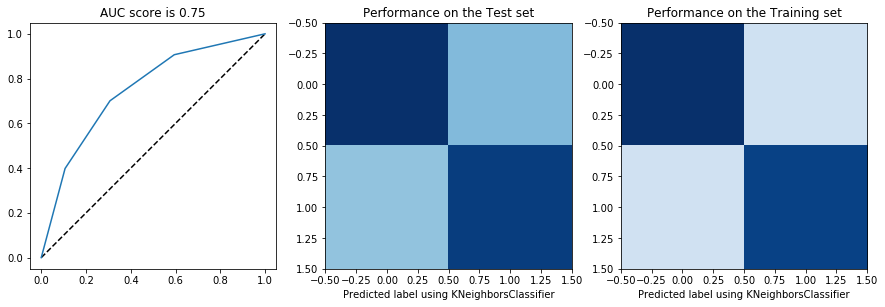

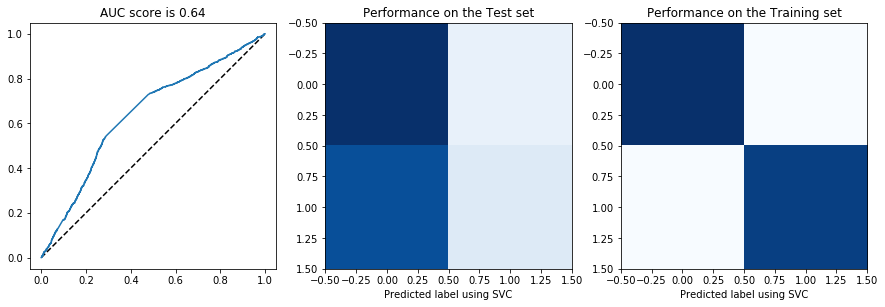

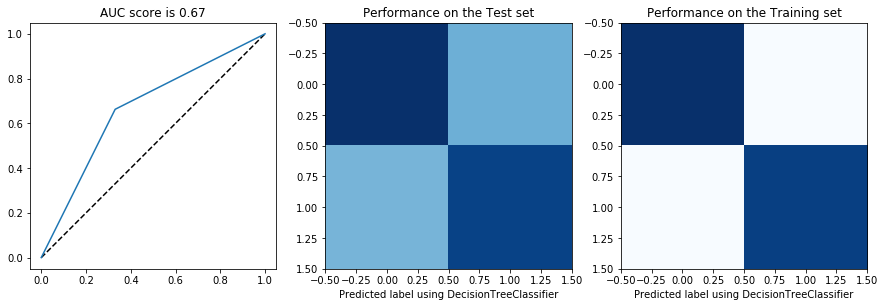

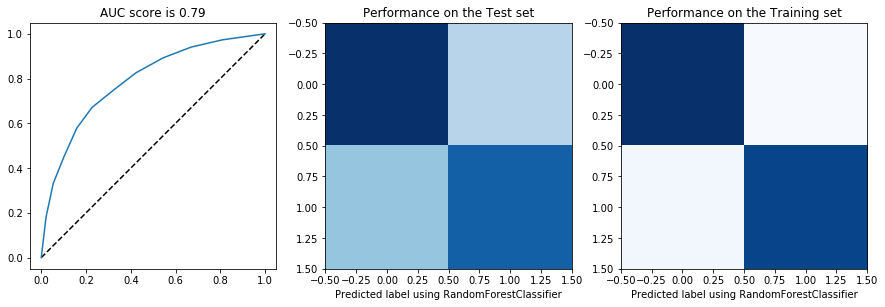

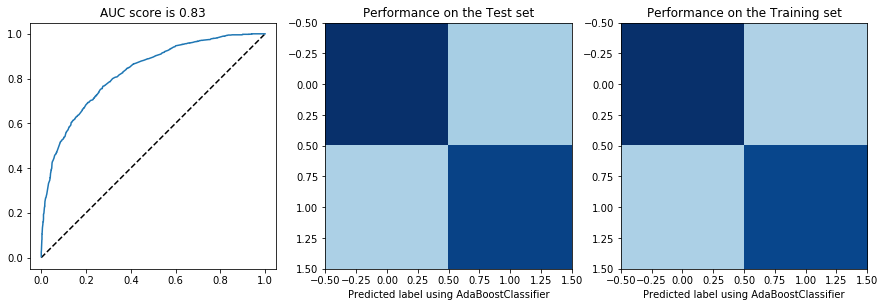

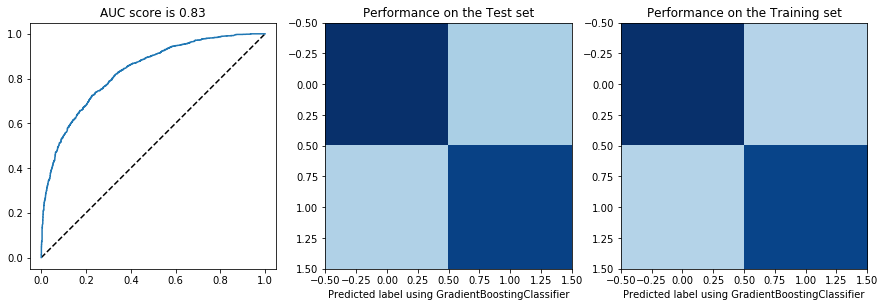

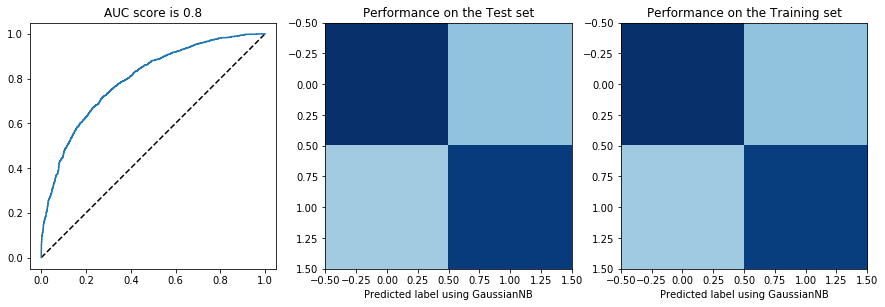

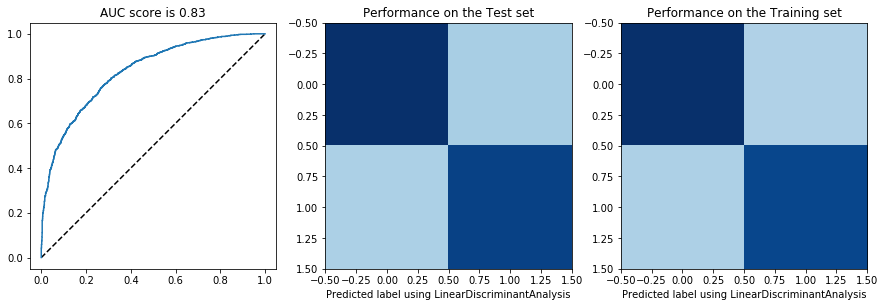

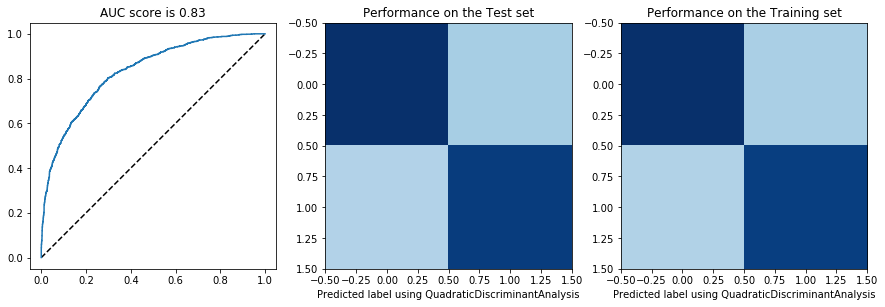

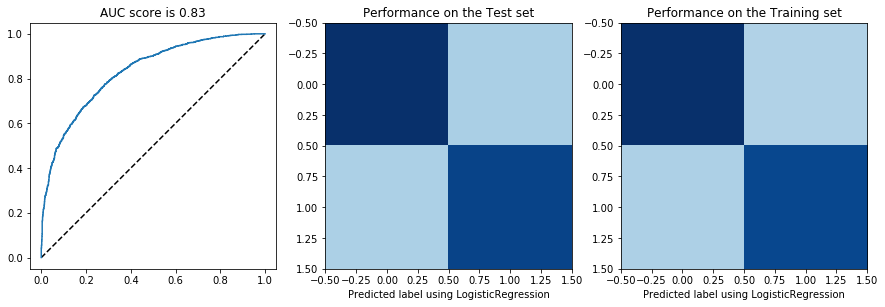

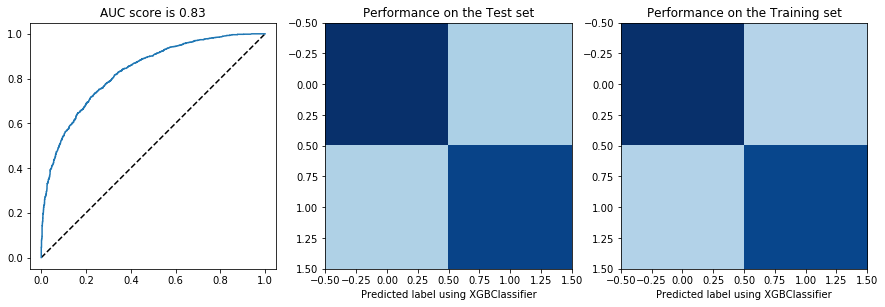

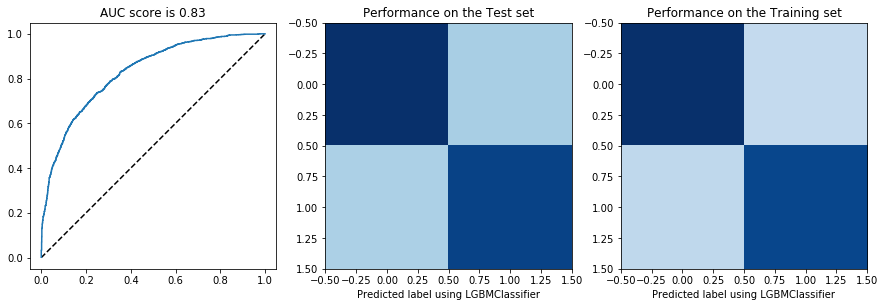

In [24]:
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier(),
    LGBMClassifier(),
]

X, y = historical_matches.loc[:,['average_rank', 'rank_difference', 'point_difference','elo_difference', 'is_stake']], historical_matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

# Loop to do fit and predictions of each classifier into the dataset
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    # figures 
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure(figsize=(15,5))
    ax = plt.subplot(1,3,1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
    ax.set_aspect(1)

    ax = plt.subplot(1,3,2)
    cm = confusion_matrix(y_test, clf.predict(X_test))
    ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

    ax.set_xlabel('Predicted label using ' + name)
    ax.set_title('Performance on the Test set')

    ax = plt.subplot(1,3,3)
    cm = confusion_matrix(y_train, clf.predict(X_train))
    ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
    ax.set_xlabel('Predicted label using ' + name)
    ax.set_title('Performance on the Training set')
    pass
    
    # Storing each score into a dict
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

# Storing the results in a DataFrame to be visualized
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

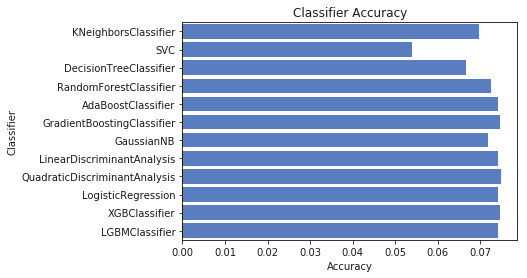

In [25]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [26]:
log.sort_values(by=['Accuracy'], ascending=False)

,Classifier,Accuracy
0,QuadraticDiscriminantAnalysis,0.074892
0,XGBClassifier,0.074675
0,GradientBoostingClassifier,0.074621
0,LinearDiscriminantAnalysis,0.074188
0,LogisticRegression,0.074188
0,LGBMClassifier,0.074134
0,AdaBoostClassifier,0.074053
0,RandomForestClassifier,0.072376
0,GaussianNB,0.071834
0,KNeighborsClassifier,0.069670


In [27]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Stakes distribution in the wrong predictions
True     0.594828
False    0.405172
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


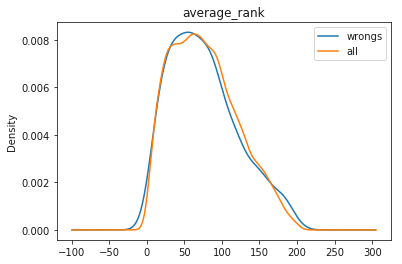

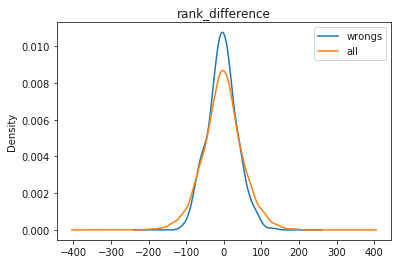

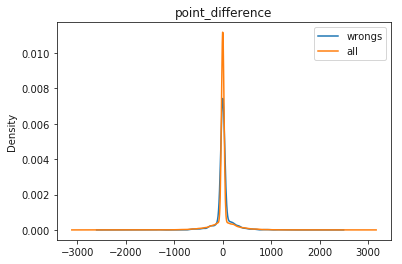

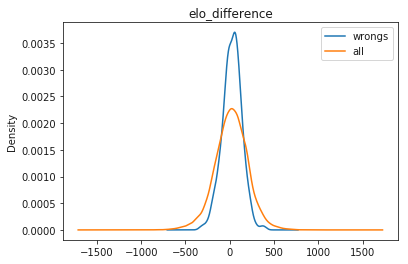

In [28]:
features = ['average_rank', 'rank_difference', 'point_difference', 'elo_difference']
wrongs = y_test != qda_model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [29]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']
margin = 0.05
world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in sorted(set(world_cup['Group'])):
    print('___Group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo_ratings']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo_ratings']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        home_win_prob = qda_model.predict_proba(row)[:,1][0] * 0.5 + xgb_model.predict_proba(row)[:,1][0] * 0.5
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Group A:___
Russia vs. Saudi Arabia: Russia wins with 0.76
Russia vs. Egypt: Russia wins with 0.69
Russia vs. Uruguay: Uruguay wins with 0.72
Saudi Arabia vs. Egypt: Egypt wins with 0.63
Saudi Arabia vs. Uruguay: Uruguay wins with 0.92
Egypt vs. Uruguay: Uruguay wins with 0.86
___Group B:___
Portugal vs. Spain: Spain wins with 0.84
Portugal vs. Morocco: Portugal wins with 0.65
Portugal vs. Iran: Iran wins with 0.60
Spain vs. Morocco: Spain wins with 0.88
Spain vs. Iran: Spain wins with 0.72
Morocco vs. Iran: Iran wins with 0.78
___Group C:___
France vs. Australia: France wins with 0.79
France vs. Peru: France wins with 0.69
France vs. Denmark: France wins with 0.75
Australia vs. Peru: Peru wins with 0.77
Australia vs. Denmark: Denmark wins with 0.63
Peru vs. Denmark: Peru wins with 0.60
___Group D:___
Argentina vs. Iceland: Argentina wins with 0.84
Argentina vs. Croatia: Argentina wins with 0.58
Argentina vs. Nigeria: Argentina wins with 0.83
Iceland vs. Croatia: Croatia wins with 0

In [30]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
print("_____Qualified Teams______\n")
print(next_round_wc.loc[:,['Group','Team','points','total_prob']])
print("\n")
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

print("_____Knockout Phase______")
finals = ['Round_of_16', 'Quarterfinal', 'Semifinal', 'Final']

labels = list()
odds = list()

for f in finals:
    print("___{}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo_ratings']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo_ratings']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        elo_prob = expected(home_elo,opp_elo)
        home_win_prob =  qda_model.predict_proba(row)[:,1][0] * 0.5 + xgb_model.predict_proba(row)[:,1][0] * 0.5
        if home_win_prob <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

_____Qualified Teams______

   Group         Team  points  total_prob
0      A      Uruguay       9    2.491644
1      A       Russia       6    1.735935
2      B        Spain       9    2.435266
3      B         Iran       6    1.662104
4      C       France       9    2.231822
5      C         Peru       6    1.675046
6      D    Argentina       9    2.253817
7      D      Croatia       6    2.008806
8      E       Brazil       9    2.653522
9      E  Switzerland       6    1.480161
10     F       Mexico       9    1.882057
11     F      Germany       6    1.707225
12     G      England       9    2.631699
13     G      Belgium       6    1.947999
14     H     Colombia       7    1.997197
15     H        Japan       7    1.973492


_____Knockout Phase______
___Round_of_16___
Uruguay vs. Iran: Iran wins with probability 0.63
France vs. Croatia: France wins with probability 0.68
Brazil vs. Germany: Brazil wins with probability 0.73
England vs. Japan: England wins with probability 0.65


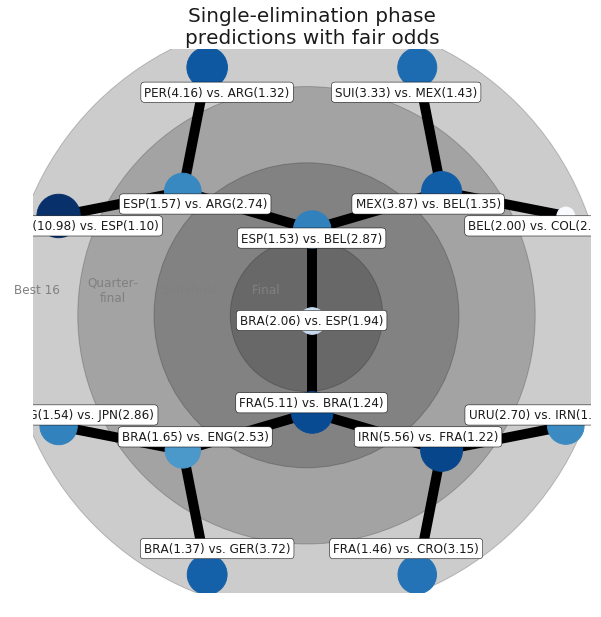

In [31]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='black', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Blues',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()